In [1]:
#Loading useful packages
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import os.path
import sys
import argparse
import warnings
warnings.filterwarnings('ignore')

#General purpose AI packages
from sklearn.cross_validation import train_test_split,KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import ParameterGrid
from sklearn.gaussian_process import GaussianProcess

#Keras packages
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, ActivityRegularization
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.optimizers import RMSprop
from keras import regularizers 

C:\ProgramData\Anaconda3\envs\PY36\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
############## LOSSHISTORY CALLBACK CLASS ######################################
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

In [3]:
DATAFILE = os.path.join('data','data.csv')
TARGETFILE = os.path.join('data','target.csv')
OUTDIR = os.path.join('results')

In [34]:
def train_nn(X_tr,Y_tr,X_val,Y_val):
    
    verbose = 1
    
    #Model callbacks
    filepath = os.path.join('results','weights.best.hdf5')
    mdlcheck = ModelCheckpoint(filepath, verbose=0, save_best_only=True)
    mdllosses = LossHistory()
    mdlstop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

    #Model fit
    n_epochs = 5000
    n_batch = 68
    kf = KFold(n = np.shape(X_tr_val)[0], n_folds = 5)
    performance_cv = []
    #mdllosses_cv = []
    models = []
    
    i = 1
    for tr_idx, val_idx in kf:
        #'activation_1': 0, 'activation_2': 1, 'activation_3': 1, 'dropout_1': 0.08813572098580352, 
        #'dropout_2': 0.03155693545556867, 'fit_n_batch': 68.0, 'n_nodes_1': 436.0, 'n_nodes_2': 969.0, 'n_nodes_3': 373.0
        #Build NN
        model = Sequential()
        model.add(Dense(units=436, input_dim=np.shape(X_tr)[1], activity_regularizer=regularizers.l2(0)))
        model.add(Activation('relu'))
        model.add(Dropout(0.0881357))
        model.add(Dense(units=969,activity_regularizer=regularizers.l2(0)))
        model.add(Activation('sigmoid'))
        model.add(Dropout(0.0315569))
        model.add(Dense(units=373,activity_regularizer=regularizers.l2(0)))
        model.add(Activation('sigmoid'))
        model.add(Dense(units=1))

        opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
        model.compile(loss='mse',optimizer=opt)
    
        print("Fold: ",i," of 5")
        i = i+1
        X_train, X_valid = X_tr_val[tr_idx], X_tr_val[val_idx]
        Y_train, Y_valid = Y_tr_val[tr_idx], Y_tr_val[val_idx]
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_valid = scaler.transform(X_valid)

        history = model.fit(X_train, Y_train, validation_data = (X_valid, Y_valid),  epochs = n_epochs, batch_size = n_batch, callbacks = [mdlstop,mdlcheck,mdllosses],verbose = verbose)
        
        #Recalling best weights and appending loss value and loss history
        model.load_weights(filepath)
        models.append(model)
        performance_cv.append(min(mdllosses.val_losses))
        #mdllosses_cv.append(mdllosses)
        
    #Calculating in-cv std 
    loss_std = np.std(performance_cv)
    
    print('Obtained loss: ', np.mean(performance_cv), ' (', loss_std, ')')
    
    return model, min(mdllosses.val_losses)

In [43]:
############## PREPARING DATA ##################################################

dataset_trans = pd.read_table(os.path.join('data','dataset_trans.csv'),sep=',')
target = np.asarray(dataset_trans['Y'])
pazienti = np.asarray(dataset_trans['subj'])
del dataset_trans['Y']
del dataset_trans['min_risk']

train = np.asarray(dataset_trans)
train_val_size = 0.8 #80% training+validation set and 20% test set
train_size = 0.7 #70% training set and 30% validation set
X_tr_val, X_te, Y_tr_val, Y_te = train_test_split(train, target, train_size=train_val_size, random_state=1)
X_tr, X_val, Y_tr, Y_val = train_test_split(X_tr_val, Y_tr_val, train_size=train_size, random_state=1)

paz_tr_val = X_tr_val[:,0]
paz_tr = X_tr[:,0]
paz_val = X_val[:,0]
paz_te = X_te[:,0]
X_tr_val = X_tr_val[:,1:14]
X_tr = X_tr[:,1:14]
X_val = X_val[:,1:14]
X_te = X_te[:,1:14]

scaler = StandardScaler().fit(X_tr)
X_tr = scaler.transform(X_tr)
X_val = scaler.transform(X_val)
X_te = scaler.transform(X_te)

model, score = train_nn(X_tr,Y_tr,X_val,Y_val)

Fold:  1  of 5
Train on 6376 samples, validate on 1594 samples
Epoch 1/5000
6376/6376 [==============================] - 1s - loss: 7074.3573 - val_loss: 6326.2687
Epoch 2/5000
6376/6376 [==============================] - 1s - loss: 6252.8688 - val_loss: 5936.4660
Epoch 3/5000
6376/6376 [==============================] - 1s - loss: 5922.2066 - val_loss: 5736.1938
Epoch 4/5000
6376/6376 [==============================] - 1s - loss: 5701.3927 - val_loss: 5498.4865
Epoch 5/5000
6376/6376 [==============================] - 1s - loss: 5459.7624 - val_loss: 5341.2253
Epoch 6/5000
6376/6376 [==============================] - 1s - loss: 5241.9286 - val_loss: 5186.6411
Epoch 7/5000
6376/6376 [==============================] - 1s - loss: 5084.9497 - val_loss: 5130.1899
Epoch 8/5000
6376/6376 [==============================] - 1s - loss: 4849.9379 - val_loss: 5024.3104
Epoch 9/5000
6376/6376 [==============================] - 1s - loss: 4695.6715 - val_loss: 4735.3621
Epoch 10/5000
6376/6376 [===

6376/6376 [==============================] - 1s - loss: 623.0457 - val_loss: 762.2336
Epoch 82/5000
6376/6376 [==============================] - 1s - loss: 595.1826 - val_loss: 765.0478
Epoch 83/5000
6376/6376 [==============================] - 1s - loss: 593.3760 - val_loss: 718.4219
Epoch 84/5000
6376/6376 [==============================] - 1s - loss: 567.9974 - val_loss: 709.3651
Epoch 85/5000
6376/6376 [==============================] - 1s - loss: 570.0272 - val_loss: 677.5880
Epoch 86/5000
6376/6376 [==============================] - 1s - loss: 556.6606 - val_loss: 639.0370
Epoch 87/5000
6376/6376 [==============================] - 1s - loss: 560.7097 - val_loss: 596.4144
Epoch 88/5000
6376/6376 [==============================] - 1s - loss: 543.3983 - val_loss: 654.6290
Epoch 89/5000
6376/6376 [==============================] - 1s - loss: 535.2833 - val_loss: 692.9696
Epoch 90/5000
6376/6376 [==============================] - 1s - loss: 529.5514 - val_loss: 641.0413
Epoch 91/5000


6376/6376 [==============================] - 1s - loss: 1313.8580 - val_loss: 1166.9857
Epoch 43/5000
6376/6376 [==============================] - 1s - loss: 1219.3631 - val_loss: 1212.5693
Epoch 44/5000
6376/6376 [==============================] - 1s - loss: 1237.1828 - val_loss: 1196.3721
Epoch 45/5000
6376/6376 [==============================] - 1s - loss: 1202.1271 - val_loss: 1149.2777
Epoch 46/5000
6376/6376 [==============================] - 1s - loss: 1149.5142 - val_loss: 1116.7741
Epoch 47/5000
6376/6376 [==============================] - 1s - loss: 1142.6054 - val_loss: 1034.4972
Epoch 48/5000
6376/6376 [==============================] - 1s - loss: 1105.1405 - val_loss: 1363.6066
Epoch 49/5000
6376/6376 [==============================] - 1s - loss: 1108.7362 - val_loss: 1074.8116
Epoch 50/5000
6376/6376 [==============================] - 1s - loss: 1109.9890 - val_loss: 1115.6496
Epoch 51/5000
6376/6376 [==============================] - 1s - loss: 1046.5224 - val_loss: 1037

6376/6376 [==============================] - 1s - loss: 349.7551 - val_loss: 411.4120
Epoch 124/5000
6376/6376 [==============================] - 1s - loss: 346.1495 - val_loss: 416.7302
Epoch 125/5000
6376/6376 [==============================] - 1s - loss: 346.2241 - val_loss: 426.6516
Epoch 126/5000
6376/6376 [==============================] - 1s - loss: 338.5194 - val_loss: 403.0557
Epoch 127/5000
6376/6376 [==============================] - 1s - loss: 330.7345 - val_loss: 451.3387
Epoch 128/5000
6376/6376 [==============================] - 1s - loss: 336.5034 - val_loss: 396.9993
Epoch 129/5000
6376/6376 [==============================] - 1s - loss: 321.7990 - val_loss: 443.2655
Epoch 130/5000
6376/6376 [==============================] - 1s - loss: 331.3677 - val_loss: 448.7519
Epoch 131/5000
6376/6376 [==============================] - 1s - loss: 313.8288 - val_loss: 430.1802
Epoch 132/5000
6376/6376 [==============================] - 1s - loss: 315.5204 - val_loss: 409.1800
Epoch

6376/6376 [==============================] - 1s - loss: 847.7206 - val_loss: 890.6635
Epoch 65/5000
6376/6376 [==============================] - 1s - loss: 834.5483 - val_loss: 761.5819
Epoch 66/5000
6376/6376 [==============================] - 1s - loss: 800.1151 - val_loss: 788.6041
Epoch 67/5000
6376/6376 [==============================] - 1s - loss: 801.8340 - val_loss: 1009.4099
Epoch 68/5000
6376/6376 [==============================] - 1s - loss: 783.6619 - val_loss: 777.9717
Epoch 69/5000
6376/6376 [==============================] - 1s - loss: 754.6102 - val_loss: 773.4395
Epoch 70/5000
6376/6376 [==============================] - 1s - loss: 754.7681 - val_loss: 777.4743
Epoch 71/5000
6376/6376 [==============================] - 1s - loss: 731.5634 - val_loss: 776.5868
Epoch 72/5000
6376/6376 [==============================] - 1s - loss: 723.7495 - val_loss: 726.2287
Epoch 73/5000
6376/6376 [==============================] - 1s - loss: 695.7415 - val_loss: 674.9171
Epoch 74/5000

6376/6376 [==============================] - 1s - loss: 271.8484 - val_loss: 394.1303
Epoch 146/5000
6376/6376 [==============================] - 1s - loss: 267.9896 - val_loss: 424.1765
Epoch 147/5000
6376/6376 [==============================] - 1s - loss: 263.7769 - val_loss: 421.8822
Epoch 148/5000
6376/6376 [==============================] - 1s - loss: 259.7042 - val_loss: 391.7604
Epoch 149/5000
6376/6376 [==============================] - 1s - loss: 253.0908 - val_loss: 398.3388
Epoch 150/5000
6376/6376 [==============================] - 1s - loss: 243.7447 - val_loss: 417.2657
Epoch 151/5000
6376/6376 [==============================] - 1s - loss: 247.7864 - val_loss: 397.3574
Epoch 152/5000
6376/6376 [==============================] - 1s - loss: 240.4183 - val_loss: 417.9129
Epoch 153/5000
6376/6376 [==============================] - 1s - loss: 248.3806 - val_loss: 372.0916
Epoch 154/5000
6376/6376 [==============================] - 1s - loss: 246.3979 - val_loss: 391.5662
Epoch

6376/6376 [==============================] - 1s - loss: 130.0618 - val_loss: 338.7296
Epoch 227/5000
6376/6376 [==============================] - 1s - loss: 125.6934 - val_loss: 324.7931
Epoch 228/5000
6376/6376 [==============================] - 1s - loss: 126.7453 - val_loss: 308.9785
Epoch 229/5000
6376/6376 [==============================] - 1s - loss: 123.2547 - val_loss: 316.8067
Epoch 230/5000
6376/6376 [==============================] - 1s - loss: 125.7356 - val_loss: 314.1241
Epoch 231/5000
6376/6376 [==============================] - 1s - loss: 122.2621 - val_loss: 314.7761
Epoch 232/5000
6376/6376 [==============================] - 1s - loss: 121.6727 - val_loss: 306.4419
Epoch 233/5000
6376/6376 [==============================] - 1s - loss: 124.9012 - val_loss: 317.6299
Epoch 234/5000
6376/6376 [==============================] - 1s - loss: 120.4619 - val_loss: 320.1627
Epoch 235/5000
6376/6376 [==============================] - 1s - loss: 123.7247 - val_loss: 324.1892
Epoch

6376/6376 [==============================] - 1s - loss: 972.1506 - val_loss: 1220.0270
Epoch 55/5000
6376/6376 [==============================] - 1s - loss: 953.3509 - val_loss: 1745.2812
Epoch 56/5000
6376/6376 [==============================] - 1s - loss: 937.5432 - val_loss: 1206.2614
Epoch 57/5000
6376/6376 [==============================] - 1s - loss: 895.8067 - val_loss: 1290.4827
Epoch 58/5000
6376/6376 [==============================] - 1s - loss: 927.8747 - val_loss: 1181.8282
Epoch 59/5000
6376/6376 [==============================] - 1s - loss: 890.9855 - val_loss: 1376.7357
Epoch 60/5000
6376/6376 [==============================] - 1s - loss: 875.8122 - val_loss: 1146.2920
Epoch 61/5000
6376/6376 [==============================] - 1s - loss: 837.7650 - val_loss: 1183.1611
Epoch 62/5000
6376/6376 [==============================] - 1s - loss: 808.7305 - val_loss: 1121.0349
Epoch 63/5000
6376/6376 [==============================] - 1s - loss: 795.1458 - val_loss: 1234.2756
Epoc

6376/6376 [==============================] - 1s - loss: 2907.4038 - val_loss: 2922.9466
Epoch 16/5000
6376/6376 [==============================] - 1s - loss: 2740.6364 - val_loss: 2775.7199
Epoch 17/5000
6376/6376 [==============================] - 1s - loss: 2662.7711 - val_loss: 2642.8118
Epoch 18/5000
6376/6376 [==============================] - 1s - loss: 2523.2306 - val_loss: 2513.5701
Epoch 19/5000
6376/6376 [==============================] - 1s - loss: 2420.1421 - val_loss: 2495.0623
Epoch 20/5000
6376/6376 [==============================] - 1s - loss: 2278.7905 - val_loss: 2423.6593
Epoch 21/5000
6376/6376 [==============================] - 1s - loss: 2207.5128 - val_loss: 2270.4138
Epoch 22/5000
6376/6376 [==============================] - 1s - loss: 2115.8080 - val_loss: 2170.2959
Epoch 23/5000
6376/6376 [==============================] - 1s - loss: 2037.0503 - val_loss: 2058.6193
Epoch 24/5000
6376/6376 [==============================] - 1s - loss: 1981.8163 - val_loss: 1950

6376/6376 [==============================] - 1s - loss: 520.5087 - val_loss: 787.0001
Epoch 97/5000
6376/6376 [==============================] - 1s - loss: 519.3456 - val_loss: 900.2827
Epoch 98/5000
6376/6376 [==============================] - 1s - loss: 489.6738 - val_loss: 711.3718
Epoch 99/5000
6376/6376 [==============================] - 1s - loss: 517.0751 - val_loss: 910.6758
Epoch 100/5000
6376/6376 [==============================] - 1s - loss: 471.5710 - val_loss: 723.7327
Epoch 101/5000
6376/6376 [==============================] - 1s - loss: 491.7549 - val_loss: 669.1869
Epoch 102/5000
6376/6376 [==============================] - 1s - loss: 484.9131 - val_loss: 713.8167
Epoch 103/5000
6376/6376 [==============================] - 1s - loss: 473.2657 - val_loss: 813.9211
Epoch 104/5000
6376/6376 [==============================] - 1s - loss: 480.5117 - val_loss: 679.2830
Epoch 105/5000
6376/6376 [==============================] - 1s - loss: 434.2766 - val_loss: 652.2833
Epoch 10

6376/6376 [==============================] - 1s - loss: 210.3317 - val_loss: 493.7397
Epoch 178/5000
6376/6376 [==============================] - 1s - loss: 205.4376 - val_loss: 498.0517
Epoch 179/5000
6376/6376 [==============================] - 1s - loss: 202.4241 - val_loss: 506.2159
Epoch 180/5000
6376/6376 [==============================] - 1s - loss: 203.6424 - val_loss: 494.5065
Epoch 181/5000
6376/6376 [==============================] - 1s - loss: 196.7783 - val_loss: 490.3729
Epoch 182/5000
6376/6376 [==============================] - 1s - loss: 195.7878 - val_loss: 482.5718
Epoch 183/5000
6376/6376 [==============================] - 1s - loss: 194.5505 - val_loss: 481.6022
Epoch 184/5000
6376/6376 [==============================] - 1s - loss: 188.4739 - val_loss: 488.7773
Obtained loss:  482.325736898  ( 150.580793656 )



 Score NN:  324.65161397


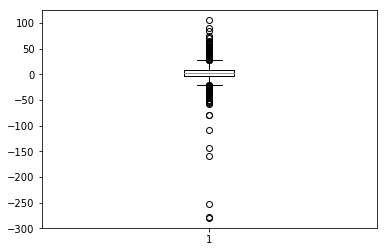

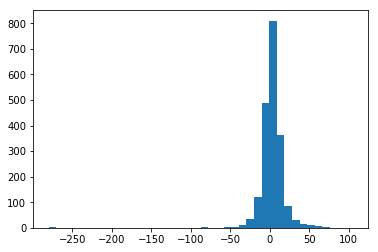

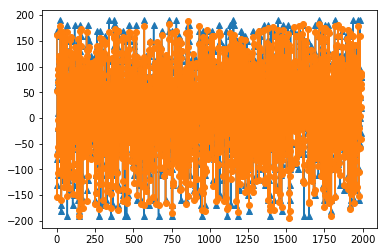

In [44]:
############## EVALUATING RESULTS  #############################################
Y_te = np.squeeze(Y_te)
Y_NN = np.squeeze(model.predict(X_te))

#MSE
print('\n Score NN: ',mean_squared_error(Y_NN,Y_te))

#Plot train and validation losses
#plt.plot(loss.losses)
#plt.plot(loss.val_losses)
#plt.show()

#Boxplot of the difference between actual values and estimates
data_to_plot = [Y_te-Y_NN]
plt.boxplot(data_to_plot)
plt.show()

#Histogram of the difference between actual values and estimates
plt.hist(data_to_plot,bins=40)
plt.show()

#Plot of the actual values and estimates
plt.plot(Y_te, marker='^')
plt.plot(Y_NN, marker='o')
plt.show()



In [31]:
np.save('Y_NN',Y_NN)
np.save('Y_te',Y_te)